In [1]:
import os,sys
import numpy as np
import scipy as sp
import pandas as pd
import matplotlib
from datetime import datetime, timedelta, time
import glob
from generate_atmosphere import LidarProfile,RadiosondeProfile
import miscLidar as mscLid
from molecular import rayleigh_scattering
import global_settings as gs
import pandas as pd
import preprocessing as prep
import matplotlib.dates as mdates
import matplotlib.pyplot as plt
import xarray as xr
%matplotlib inline

C:\Users\addalin\Dropbox\Lidar\code\miscLidar.py:40: MatplotlibDeprecationWarning: Support for setting the 'text.latex.preamble' or 'pgf.preamble' rcParam to a list of strings is deprecated since 3.3 and will be removed two minor releases later; set it to a single string instead.
  plt.rcParams['text.latex.preamble'] = [r"\usepackage{amsmath}"]


In [2]:
SMALL_SIZE = 12
MEDIUM_SIZE = 14
BIG_SIZE = 16

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=BIG_SIZE)       # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIG_SIZE)     # fontsize of the figure title

In [3]:
def get_time_slice_dataset(dataset, start_time, end_time):
	sub_ds = dataset.sel(Time =slice(start_time,end_time))
	return(sub_ds)

def humanbytes(B):
   'Return the given bytes as a human friendly KB, MB, GB, or TB string'
   B = float(B)
   KB = float(1024)
   MB = float(KB ** 2) # 1,048,576
   GB = float(KB ** 3) # 1,073,741,824
   TB = float(KB ** 4) # 1,099,511,627,776

   if B < KB:
      return '{0} {1}'.format(B,'Bytes' if 0 == B > 1 else 'Byte')
   elif KB <= B < MB:
      return '{0:.2f} KB'.format(B/KB)
   elif MB <= B < GB:
      return '{0:.2f} MB'.format(B/MB)
   elif GB <= B < TB:
      return '{0:.2f} GB'.format(B/GB)
   elif TB <= B:
      return '{0:.2f} TB'.format(B/TB)

In [20]:
'''set day'''
day_date = datetime(2017,9,15)
print(day_date)

2017-09-15 00:00:00


In [21]:
'''set station'''
print('load station')
haifa_station = gs.Station('Haifa')
#haifa_station.location
haifa_station

load station


Station()

In [22]:
''''Set paths for small tests'''
#lidar_parent_folder = 'H:\data_haifa\DATA FROM TROPOS\data\level1a\PollyXT_TROPOS'
#gdas_parent_folder = 'H:\data_haifa\DATA FROM TROPOS\GDAS\haifa'
#lidar_parent_folder = haifa_station.lidar_src_folder
# changing the path for dev

'''haifa_station.gdas1_folder = os.path.join('.','data examples','gdas')
haifa_station.gdastxt_folder  = os.path.join('.','data examples','gdas_txt')
haifa_station.molecular_dataset =  os.path.join('.','data examples','molecular_dataset')
haifa_station.lidar_dataset = os.path.join('.','data examples','lidar_dataset')
haifa_station.lidar_src_folder = os.path.join('.','data examples','netcdf')
'''
print(haifa_station)

<class 'global_settings.Station'>: {'name': 'Haifa', 'location': 'Haifa', 'lon': 35.02, 'lat': 32.8, 'altitude': 229.0, 'start_bin_height': 78.75, 'end_bin_height': 22485.66016, 'n_bins': 3000, 'dt': 5.0000000000000004e-08, 'gdas1_folder': 'H:\\data_haifa\\DATA FROM TROPOS\\GDAS\\haifa', 'gdastxt_folder': 'H:\\data_haifa\\DATA FROM TROPOS\\GDAS\\haifa_preproc', 'lidar_src_folder': 'H:\\data_haifa\\DATA FROM TROPOS\\data\\level1a\\PollyXT_TROPOS', 'molecular_dataset': 'H:\\data_haifa\\DATA FROM TROPOS\\molecular_dataset', 'lidar_dataset': 'H:\\data_haifa\\DATA FROM TROPOS\\lidar_dataset', 'db_file': 'H:\\data_haifa\\DATA FROM TROPOS\\data\\level1a\\PollyXT_TROPOS\\pollyxt_tropos_calibration.db'}


In [23]:
CONVERT_GDAS = False
SINGLE_DAY = False
if CONVERT_GDAS:
	if SINGLE_DAY:
		#convert cur day (gdas files from TROPOS to txt)
		gdastxt = prep.convert_daily_gdas ( haifa_station, day_date)
		print('gdas_txt',gdastxt)

		#convert next day (gdas files from TROPOS to txt)
		next_day = day_date + timedelta ( days = 1 )
		gdastxt_nextday = prep.convert_daily_gdas ( haifa_station, next_day )
		print('gdas_txt next day',gdastxt_nextday)

	else:
		#%% convert gdas files for a period
		start_day =  datetime(2017,9,1)
		end_day = datetime(2017,9,30)
		chunk_paths = prep.convert_periodic_gdas(haifa_station,start_day, end_day)
		print(chunk_paths)

In [24]:
SHOW_MOL_DF = False
if SHOW_MOL_DF:
	'''set parameters'''
	lambda_nm = gs.LAMBDA_nm().G
	df_sigma , df_beta = prep.get_daily_molecular_profiles( haifa_station , day_date , lambda_nm , 'Km' )
	# Visualizing molecular profiles

	plt.figure()
	ax = df_beta.plot()
	ax.set_ylabel(r'$\beta_{\rm mol}[1/m]$')
	plt.show()

In [25]:
# for profiling un-highlight the line below
# %%prun -s cumulative
CREATE_MOL_DS = True
if CREATE_MOL_DS:
	print(f"Create daily molecular dataset for {day_date}")
	ds =  prep.generate_daily_molecular(haifa_station,day_date,optim_size = True)
	print(ds)

Create daily molecular dataset for 2017-09-15 00:00:00
<xarray.Dataset>
Dimensions:     (Height: 3000, Time: 2880, Wavelength: 3)
Coordinates:
  * Height      (Height) float64 0.3078 0.3152 0.3227 ... 22.7 22.71 22.71
  * Time        (Time) datetime64[ns] 2017-09-15 ... 2017-09-15T23:59:30
  * Wavelength  (Wavelength) uint64 355 532 1064
Data variables:
    beta        (Wavelength, Height, Time) float32 7.6450815e-06 ... 4.993783...
    sigma       (Wavelength, Height, Time) float32 6.500143e-05 ... 4.240941e-08
    attbsc      (Wavelength, Height, Time) float32 7.875788e-06 ... 4.9954108...
    lambda_nm   (Wavelength) uint16 355 532 1064
    date        datetime64[ns] 2017-09-15
Attributes:
    location:  Haifa


In [26]:
SAVE_MOL_DS = True
if SAVE_MOL_DS:
	print('Saving dataset to:')
	netcdfs = prep.save_molecular_dataset(haifa_station,ds,save_mode='both')
	print(netcdfs)

Saving dataset to:
['H:\\data_haifa\\DATA FROM TROPOS\\molecular_dataset\\2017\\09\\2017_09_15_Haifa_beta_355_molecular.nc', 'H:\\data_haifa\\DATA FROM TROPOS\\molecular_dataset\\2017\\09\\2017_09_15_Haifa_beta_532_molecular.nc', 'H:\\data_haifa\\DATA FROM TROPOS\\molecular_dataset\\2017\\09\\2017_09_15_Haifa_beta_1064_molecular.nc', 'H:\\data_haifa\\DATA FROM TROPOS\\molecular_dataset\\2017\\09\\2017_09_15_Haifa_sigma_355_molecular.nc', 'H:\\data_haifa\\DATA FROM TROPOS\\molecular_dataset\\2017\\09\\2017_09_15_Haifa_sigma_532_molecular.nc', 'H:\\data_haifa\\DATA FROM TROPOS\\molecular_dataset\\2017\\09\\2017_09_15_Haifa_sigma_1064_molecular.nc', 'H:\\data_haifa\\DATA FROM TROPOS\\molecular_dataset\\2017\\09\\2017_09_15_Haifa_attbsc_355_molecular.nc', 'H:\\data_haifa\\DATA FROM TROPOS\\molecular_dataset\\2017\\09\\2017_09_15_Haifa_attbsc_532_molecular.nc', 'H:\\data_haifa\\DATA FROM TROPOS\\molecular_dataset\\2017\\09\\2017_09_15_Haifa_attbsc_1064_molecular.nc', 'H:\\data_haifa\\DATA F

In [27]:
TEST_LOAD_DS = False
if TEST_LOAD_DS:
	netcdf = netcdfs[-1]
	ds_load = prep.load_dataset(netcdf)
	print(ds_load)

In [28]:
if TEST_LOAD_DS:
	netcdf = netcdfs[-2]
	ds_load_prof = prep.load_dataset(netcdf)
	print(ds_load_prof)

In [29]:
VIS_DS = False
if VIS_DS:
	profileTypes = list(ds.data_vars)[0:3]
	#list(ds.data_vars)[3:]
	xfmt = mdates.DateFormatter('%H:%M')
	timetics = ds.Time.dt.strftime('%H:%M')
	timetics

	for row,prof in enumerate(profileTypes):
		ds_var = ds[prof]
		g = ds_var.plot(x='Time',y='Height',col='Wavelength',
		                  col_wrap = 3,cmap = 'turbo')# , figsize = (5,8)) #TODO: figure out how to enlarge the figsize, it doesn't work properly :-(
		for ax in g.axes.flat:
			ax.xaxis.set_major_formatter(xfmt)
			ax.xaxis_date()
			ax.get_xaxis().set_major_locator(mdates.HourLocator(interval=4))
			plt.setp( ax.get_xticklabels(), rotation=0,horizontalalignment='center')
			#if row in [0,1]:
			#	ax.xaxis.set_ticklabels([])
			#	ax.set_xlabel(None)
			#if row in [1,2]:
			#	ax.set_title(None)

		date_64 = ds.date.values
		date_datetime = datetime.utcfromtimestamp(date_64.tolist()/1e9)
		date_str = date_datetime.strftime('%d/%m/%Y')
		plt.suptitle('{} - {} {}'.format(ds_var.attrs['info'],ds.attrs['location'],date_str), y = 1.05)
		#plt.tight_layout()
		plt.show()

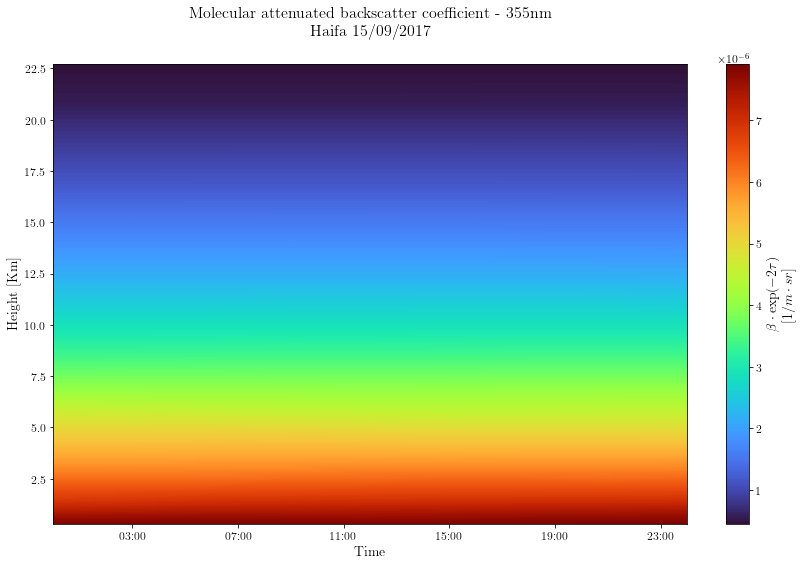

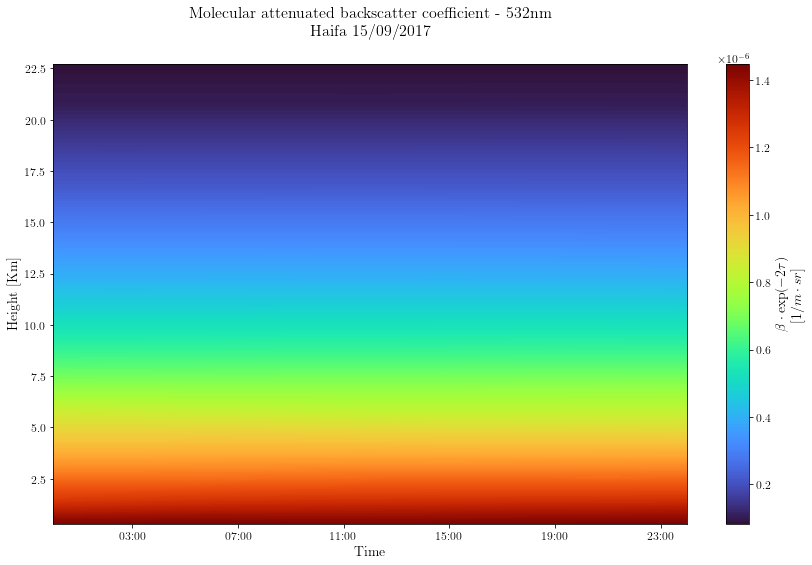

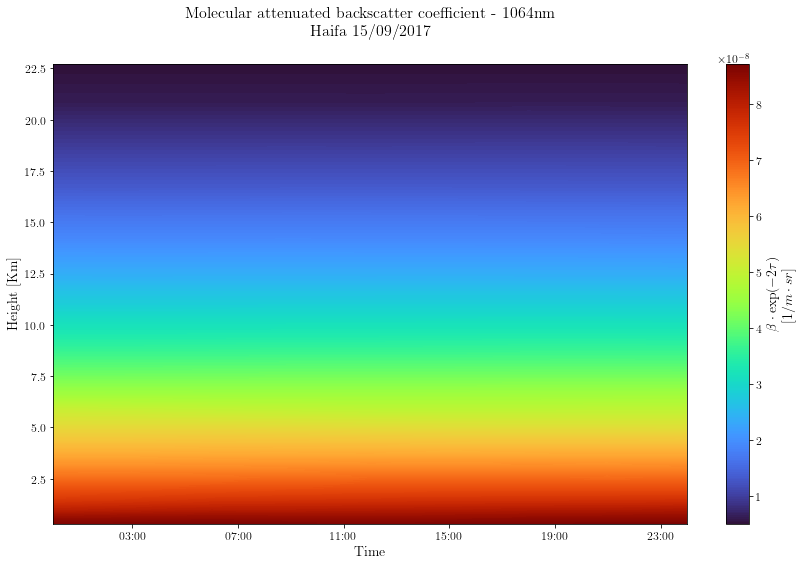

In [30]:
VIS_ATTBSC = False
if VIS_ATTBSC:
	wavelengths = ds.Wavelength.values.tolist()
	for wav in wavelengths:
		 prep.visualize_ds_profile_chan(ds, wav,profile_type = 'attbsc', USE_RANGE=True)

In [31]:
RUN_PD= False
if RUN_PD:
	print('retrieve a sub-dataframe from a dataset - according wavelength')
	df_test_beta = ds.beta.sel(Wavelength=355).to_pandas()
	df_test_beta

In [32]:
RUN_SLICE= False
if RUN_SLICE:
	print('retrieve a sub-dataframe from a dataset - according time slice')

	start_time = datetime(2017,9,2,0,30)
	end_time = start_time + timedelta(minutes = 29.5) #datetime(2017,9,1,12,30)
	timestamps = pd.date_range ( start = start_time , end = end_time  ,
	                             freq = timedelta ( seconds = 30 ) )
	#slice_beta= mol_xr.loc['beta'].to_pandas().loc[:,timestamps]
	print('slicing data set by time')
	sub_ds = get_time_slice_dataset(ds, start_time, end_time)#  timestamps).plot()#=slice(start_time,start_time+timedelta(hours = 6)))

	print(sub_ds)

In [33]:
CALC_SIZE = False
if CALC_SIZE:
	profiles = list(ds.data_vars)[0:3]
	total_size =0
	for prof in profiles:
		for wav in ds.Wavelength.values:
			tmp_prof = (ds[prof]).sel(Wavelength=wav).to_pandas()
			cursize = tmp_prof.memory_usage(deep=True).sum()
			print('profile:{}, wavelength: {}, size:{}'.format(prof,wav,humanbytes(cursize)))
			total_size+=cursize

	print('total size of data set is at least:{}'.format(humanbytes(total_size)))


In [34]:
print('get range corrected from TROPOS')
ds_range_corr_daily =  prep.get_daily_range_corr(haifa_station, day_date,height_units ='Km',
                                                 optim_size = True, verbose = False)
ds_range_corr_daily

get range corrected from TROPOS


<xarray.Dataset>
Dimensions:         (Height: 3000, Time: 1790, Wavelength: 3)
Coordinates:
  * Time            (Time) datetime64[ns] 2017-09-15 ... 2017-09-15T14:54:30
  * Height          (Height) float64 0.3088 0.3162 0.3237 ... 22.7 22.71 22.72
  * Wavelength      (Wavelength) uint64 355 532 1064
Data variables:
    range_corr      (Wavelength, Height, Time) float32 230346.44 ... -4377531.5
    lambda_nm       (Wavelength) uint32 355 532 1064
    plot_min_range  (Wavelength) float64 0.0 0.0 0.0
    plot_max_range  (Wavelength) float64 9.378e+07 8.627e+07 5.739e+07
    date            datetime64[ns] 2017-09-15
Attributes:
    location:  Haifa
    info:      Daily range corrected lidar signal

visualizing with range_plot bounding values:


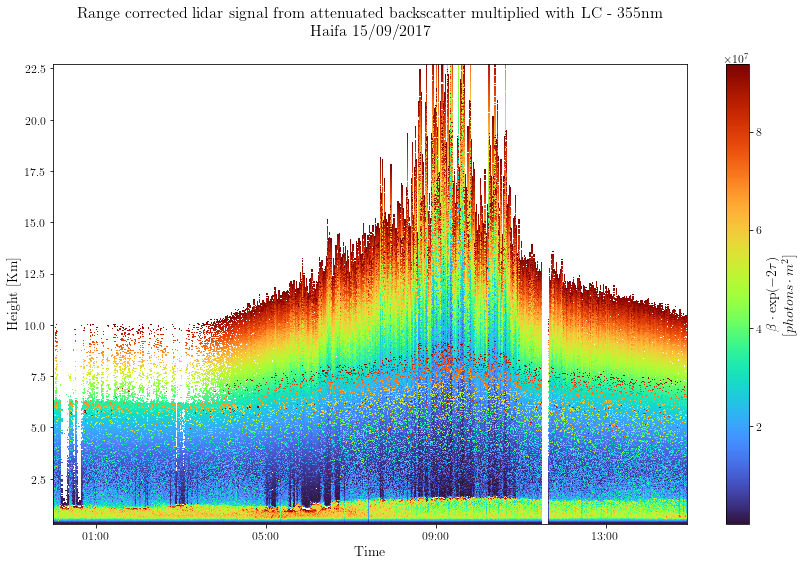

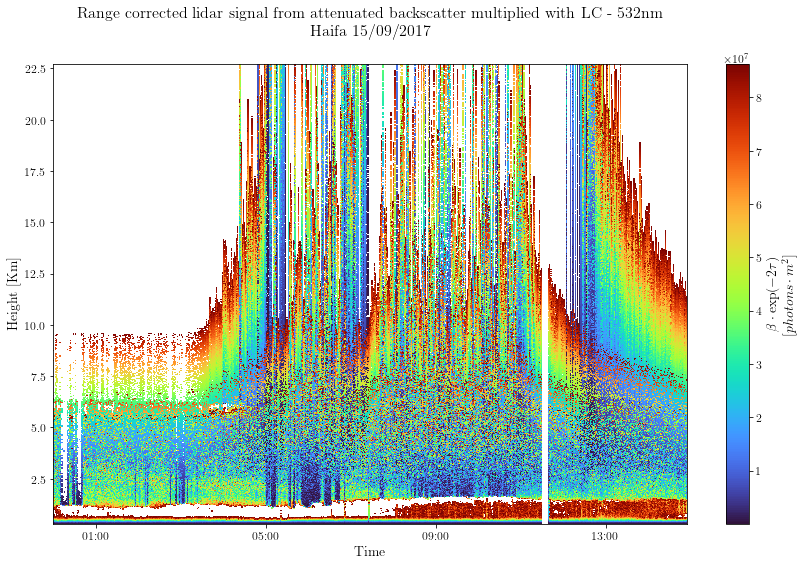

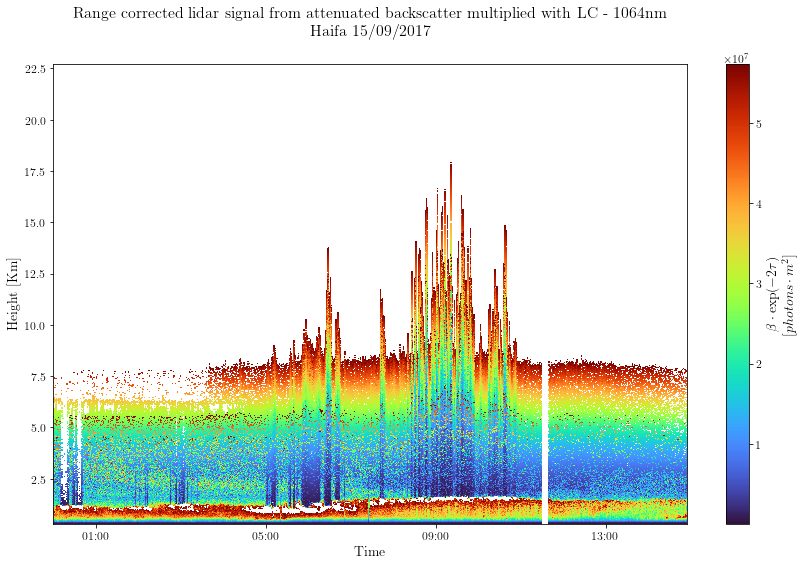

In [35]:
print('visualizing with range_plot bounding values:')

wavelengths = ds_range_corr_daily.Wavelength.values.tolist()
for wav in wavelengths:
	 prep.visualize_ds_profile_chan(ds_range_corr_daily, wav,profile_type = 'range_corr', USE_RANGE=True)

visualizing without range_plot:


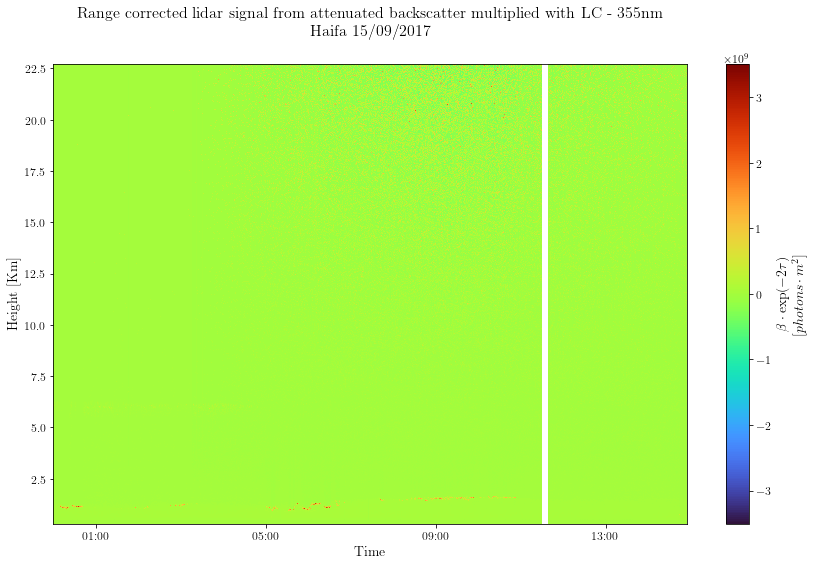

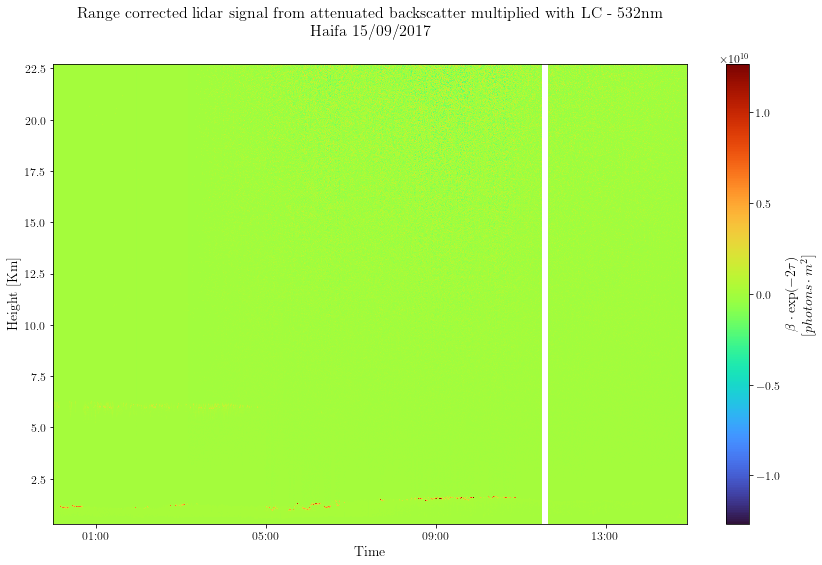

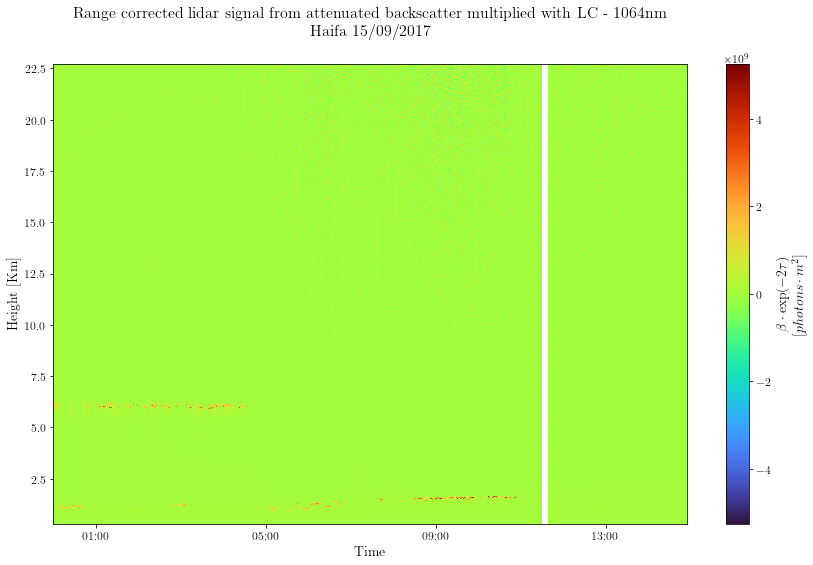

In [36]:
print('visualizing without range_plot:')
for wav in wavelengths:
	 prep.visualize_ds_profile_chan(ds_range_corr_daily, wav, profile_type = 'range_corr',USE_RANGE=False)

In [37]:
print('Save range corrected dataset')
lidar_ncpaths =  prep.save_range_corr_dataset(haifa_station,ds_range_corr_daily,save_mode='both')
lidar_ncpaths


Save range corrected dataset


['H:\\data_haifa\\DATA FROM TROPOS\\lidar_dataset\\2017\\09\\2017_09_15_Haifa_range_corr_355_lidar.nc',
 'H:\\data_haifa\\DATA FROM TROPOS\\lidar_dataset\\2017\\09\\2017_09_15_Haifa_range_corr_532_lidar.nc',
 'H:\\data_haifa\\DATA FROM TROPOS\\lidar_dataset\\2017\\09\\2017_09_15_Haifa_range_corr_1064_lidar.nc',
 'H:\\data_haifa\\DATA FROM TROPOS\\lidar_dataset\\2017\\09\\2017_09_15_Haifa_range_corr_lidar.nc']

In [38]:
TEST_LOAD_DS_LIDAR = False
if TEST_LOAD_DS_LIDAR:
	print( 'Load range corr in all channels')

	netcdf = lidar_ncpaths[-1]
	ds_pr2_load =  prep.load_dataset(netcdf)
	print(ds_pr2_load)

In [39]:
if TEST_LOAD_DS_LIDAR:
	print( 'Load range corr per channel')
	netcdf = lidar_ncpaths[0]
	ds_load_pr2_chan = prep.load_dataset(netcdf)
	print(ds_load_pr2_chan)


In [40]:
TEST_PROFILES_PATHS=False
if TEST_PROFILES_PATHS:
	profiles_paths = prep.get_TROPOS_dataset_paths(haifa_station.lidar_src_folder, day_date, file_type = 'profiles')
	print(profiles_paths)
	prof_path = profiles_paths[0]

In [41]:
'''
np.finfo(np.float64)
print(np.finfo(np.float64).max)
print(np.finfo(np.float64).min)
print(np.finfo(np.float32).max)
print(np.finfo(np.float32).min)
'''

'\nnp.finfo(np.float64)\nprint(np.finfo(np.float64).max)\nprint(np.finfo(np.float64).min)\nprint(np.finfo(np.float32).max)\nprint(np.finfo(np.float32).min)\n'

In [42]:
# TODO: split each sataset of range corrected to 2 : one contains the exponent of 10 , and the other the base (less importanat for now)
# TODO: range corrected values? how come the range corrected has large negative values?
# ASK which months are reanalyzed?
# TODO: Load X as pytorch from xarray.dataset and split to time slices
# TODO: convert height bins into heatmap
# TODO: lidar_parent_folder - should be similar to lidar_src_folder. why was added to stations.csv?
# TODO: update environment installations ARLreader and pytorch
# TODO: run create dataset for all days in september

## AERONET : https://aeronet.gsfc.nasa.gov/cgi-bin/data_display_aod_v3?site=Technion_Haifa_IL&nachal=0&year=2017&month=5&day=19&aero_water=0&level=3&if_day=0&if_err=0&place_code=10&DATA_TYPE=-999&year_or_month=3
## it is possible to merge with Terra MODIS or Aqua MODIS -
# / TODO: locate the function that does donwload of sunphotometer data to cameranetwork (maybe Shubi knows this)
# / TODO: ask about the relevant product from MODIS to our porpose.

# QUESTIONS:
# 1. How does the plot_range was set up?
# 2. How can I get realistic values for lidar measurements ? (without negative values? )

In [43]:
'''
xfmt = mdates.DateFormatter('%H:%M')
timetics = ds_range_corr_daily.Time.dt.strftime('%H:%M')
timetics


g = ds_range_corr_daily.range_corr.plot(x='Time',y='Height',col='Wavelength',
                  col_wrap = 3,cmap = 'turbo', figsize= (15,8))# , figsize = (5,8)) #TODO: figure out how to enlarge the figsize, it doesn't work properly :-(
for ax in g.axes.flat:
	ax.xaxis.set_major_formatter(xfmt)
	ax.xaxis_date()
	ax.get_xaxis().set_major_locator(mdates.HourLocator(interval=4))
	plt.setp( ax.get_xticklabels(), rotation=0,horizontalalignment='center')

date_64 = ds_range_corr_daily.date.values
date_datetime = datetime.utcfromtimestamp(date_64.tolist()/1e9)
date_str = date_datetime.strftime('%d/%m/%Y')
plt.suptitle('{} - {} {}'.format(ds_range_corr_daily.attrs['info'],ds_range_corr_daily.attrs['location'],date_str), y = 1.05)
#plt.tight_layout()
plt.show()
'''

"\nxfmt = mdates.DateFormatter('%H:%M')\ntimetics = ds_range_corr_daily.Time.dt.strftime('%H:%M')\ntimetics\n\n\ng = ds_range_corr_daily.range_corr.plot(x='Time',y='Height',col='Wavelength',\n                  col_wrap = 3,cmap = 'turbo', figsize= (15,8))# , figsize = (5,8)) #TODO: figure out how to enlarge the figsize, it doesn't work properly :-(\nfor ax in g.axes.flat:\n\tax.xaxis.set_major_formatter(xfmt)\n\tax.xaxis_date()\n\tax.get_xaxis().set_major_locator(mdates.HourLocator(interval=4))\n\tplt.setp( ax.get_xticklabels(), rotation=0,horizontalalignment='center')\n\ndate_64 = ds_range_corr_daily.date.values\ndate_datetime = datetime.utcfromtimestamp(date_64.tolist()/1e9)\ndate_str = date_datetime.strftime('%d/%m/%Y')\nplt.suptitle('{} - {} {}'.format(ds_range_corr_daily.attrs['info'],ds_range_corr_daily.attrs['location'],date_str), y = 1.05)\n#plt.tight_layout()\nplt.show()\n"

In [44]:
'''
import logging
logger = logging.getLogger()

day_dates = pd.date_range(start=start_day, end=end_day, freq=timedelta(days=1))
expected_file_no = len(day_dates) * 8  # 8 timestamps per day
gdastxt_paths = []
for day in day_dates:
    gdastxt_paths.extend(prep.convert_daily_gdas(haifa_station, day))
total_converted = len(gdastxt_paths)
logger.debug(f"Done conversion of {total_converted} gdas files from {start_day.strftime('%Y/%m/%d')} to "
             f"{end_day.strftime('%Y/%m/%d')}, {(expected_file_no - total_converted)} failed.")

'''

'\nimport logging\nlogger = logging.getLogger()\n\nday_dates = pd.date_range(start=start_day, end=end_day, freq=timedelta(days=1))\nexpected_file_no = len(day_dates) * 8  # 8 timestamps per day\ngdastxt_paths = []\nfor day in day_dates:\n    gdastxt_paths.extend(prep.convert_daily_gdas(haifa_station, day))\ntotal_converted = len(gdastxt_paths)\nlogger.debug(f"Done conversion of {total_converted} gdas files from {start_day.strftime(\'%Y/%m/%d\')} to "\n             f"{end_day.strftime(\'%Y/%m/%d\')}, {(expected_file_no - total_converted)} failed.")\n\n'

In [45]:
#file_type = 'NR_profiles'
#print( 'files' in file_type)

In [46]:
#import glob
#dirn = r"H:\\data_haifa\\DATA FROM TROPOS\\data\\level1a\\PollyXT_TROPOS\\2017\\09\\01\\*_0000_0059_profiles.nc"
#glob.glob(dirn)#pattern =  r"H:\\data_haifa\\DATA FROM TROPOS\\data\\level1a\\PollyXT_TROPOS\\2017\\09\\01\\*[0-9]_profile.nc"
#print(glob.glob(pattern))